In [1]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
from tqdm import tqdm_notebook
from functools import reduce

In [2]:
idx = pd.IndexSlice
rc = ipp.Client()#('/home/julian/.ipython/profile_ssh/security/ipcontroller-client.json')
dview = rc.load_balanced_view()
print(rc.ids)

def send_file(dview, local_path, remote_path):
    """Send a single file"""
    print("sending file", local_path, remote_path)
    import io, os
    
    def _recv(remote_path, bdata, mtime):
        import io, os
        if os.path.exists(remote_path):
            os.unlink(remote_path)
        with io.open(remote_path, 'wb') as f:
            f.write(data)
        os.utime(remote_path, (mtime, mtime))
    
    st = os.stat(local_path)
    with io.open(local_path, 'rb') as f:
        data = f.read()
    
    yield dview.apply_async(_recv, remote_path, data, st.st_mtime)
    
#TODO: use chrpath PyVal.so -r . to make libtrng visible
#for el in send_file(dview, '../build/PyVal.cpython-36m-x86_64-linux-gnu.so','./PyVal.so'):
    
    print(el.get())
for el in send_file(dview, '../external/lib/libtrng4.so.19', './libtrng4.so.19'):
    pass
for el in send_file(dview, '../external/lib/libtrng4.so', './libtrng4.so'):
    pass

with rc[:].sync_imports():
    import PyVal
    import numpy as np


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
sending file ../external/lib/libtrng4.so.19 ./libtrng4.so.19


KeyboardInterrupt: 

In [4]:
#@ipp.require('PyVal', 'numpy')
def run_sim(N, row_val, col_val, p, T, r, default_scale):
    import numpy as np
    N_MC = 600
    N_nets = 800
    nw = PyVal.BS_Network()
    MList = []
    rsList= []
    assetList= []
    deltaList = []
    solventList = []
    MVarList = []
    rsVarList= []
    assetVarList= []
    deltaVarList = []
    solventVarList = []
    nSamplesList = []
    ioDistList = []
    ioDistVarList = []
    #vOutList = []
    print("Runing N=" +str(N)+ ", row sum="+str(row_val)+"col sum="+str(col_val)+", p="+str(p))
    nw.run(N, p, row_val, col_val, 2, T, r, N_MC,  N_nets, default_scale)
    res = {'N_MC': N_MC, 'N_nets': N_nets ,'N': N, 'Number Of Samples': nw.get_N_samples()[:,0], 'default scale': default_scale,\
           'conn': N*p, 'row sum': row_val, 'col sum': col_val, 'T':T, 'r': r ,'p': p, \
           'M': nw.get_M(), 'M var': nw.get_M_var(),\
           'In/Out Degree Distribution': np.array(nw.get_io_deg_dist())[:,0], 'In/Out Degree Distribution var': np.array(nw.get_io_deg_dist_var())[:,0],\
           'Assets': np.array(nw.get_assets())[:,0], 'Assets var': np.array(nw.get_assets_var())[:,0],\
           'RS': np.array(nw.get_rs())[:,0],  'RS var': np.array(nw.get_rs_var())[:,0],\
           'Delta': nw.get_delta_jacobians(),  'Delta var': nw.get_delta_jacobians_var(),\
           'Solvent': np.array(nw.get_solvent())[:,0], 'Solvent var': np.array(nw.get_solvent_var())[:,0]}
    return res

# callapses a list of results into a single result.
# returns a tuple: (Collapsed result, list of results with wrong parameters)
# TODO: allow for collaps along, r, T, val, N. for now only p
# TODO: sort along collapse axis
def combine_results(*results):
    r0 = results[0]
    res_new = r0.copy()
    failed = []
    if type(r0) is not dict:
        print("WARNING! Did recieve non-dict type as parameter")
    

    def combine(el):
        if r0['val'] != el['val'] or r0['N'] != el['N']\
        or r0['T'] != el['T'] or r0['r'] != el['r']:
            return False
        for key, value in el.items():
            if key == 'val' or key == 'N' or key == 'T' or key == 'r':
                continue
            if type(el[key]) is not list:
                print("WARNING! Key: " + key + " is not a list")
            res_new[key] = res_new[key] + el[key]
        return True
            
    for el in results[1:]:
        if type(el) is not dict:
            print("WARNING! Did recieve non-dict type as parameter")
        if not combine(el):
            failed.append(el)
            
    return (res_new, failed)

def flatten_input(cell):
    if type(cell) is list:
        return cell[0]
    else:
        return cell

def pList(N, pts):
    import numpy as np
    #    return np.union1d(np.union1d(np.linspace(0.0, 10.0/N, pts), np.linspace(0.6/N,1.4/N,pts)), np.linspace((np.log(N)-np.log(N)/7.)/N,(np.log(N)+np.log(N)/7.)/N,pts))
    #return np.union1d(np.linspace(0.0, 2.0/N, pts), np.union1d(np.linspace(0.0, 20.0/N, pts), np.linspace(0.7/N, (np.log(N)+np.log(N)/7.)/N, 2*pts)))
    return np.linspace(0.0, 1.0/N, pts)

# Parameters
## Black Scholes
    - T = 1
    - r = 0
    
## Network Parameters
    - N = [15, 25, 50, 75, 100, 150, 200, 300]
    - <k> = n*p = [0 .. 1.8]
    - M => ER(N,p)

In [5]:
Nlist = [200]
NPoints = 1
default_scale = 0.2
in_0_5_test = [(N,1.0, 1.0, el, 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
rrrr = run_sim(*(in_0_5_test[0]))

Runing N=200, row sum=1.0col sum=1.0, p=0.0


KeyboardInterrupt: 

In [ ]:
rrrr

In [64]:
plt.scatter(pList(200,10),np.ones(pList(200,10).shape[0]))

In [9]:
dview.block=False
Nlist = [20, 40, 50, 75, 100, 200]
NPoints = 10
default_scale = 3.5
in_0_05 = [(N,0.05, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_1 = [(N,0.1, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]   #, (25,0.1,pList(25,8)), (50,0.1,pList(50,6)), (75, 0.1, pList(75,6))]#, (100, 0.1, pList(100,4)), (200, 0.1, pList(200,2))]
in_0_2 = [(N,0.2, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_3 = [(N,0.3, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_35 = [(N,0.35, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_4 = [(N,0.4, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_45 = [(N,0.45, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_5 = [(N,0.5, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]
in_0_9 = [(N,0.6, [el], 1.0, 0.0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1]]

async_res = []
ids = []
for el in in_0_5:
    b_re = dview.apply_async(run_sim, *el)
    async_res.append(b_re)
    ids.extend(b_re.msg_ids)

    #rc.get_result(ids, owner=False).wait_interactive(timeout=30)

In [86]:
print('unfinished jobs: ' + str(len(rc.result_status(ids)['pending'])) + '/' + str(len(rc.result_status(ids)['completed']) + len(rc.result_status(ids)['pending'])) + str('. Running on ') + str(len(rc.ids)) + ' nodes')

unfinished jobs: 0/180. Running on 28 nodes


In [87]:
res_0_5_default_3_5 = [r.get() for r in async_res]
output = open('res_0_5_default_3_5.pkl', 'wb')
pickle.dump(res_0_5_default_3_5, output)
output.close()

RemoteError: AttributeError('PyVal.BS_Network' object has no attribute 'get_N_samples')

In [59]:
np.array(res_0_05_default_1_5[0]['M'][0]).shape

(200, 400)

# Plots

In [48]:
def flatten_input(cell):
    if type(cell) is list:
        return cell[0]
    else:
        return cell
inf = open('res_0_05_default_1_5.pkl', 'rb') #'res_0_1_newnew.pkl'
t1 = pickle.load(inf)
inf.close()
inf = open('res_0_2_newnew.pkl', 'rb')
t2 = pickle.load(inf)
inf.close()
inf = open('res_0_3_newnew.pkl', 'rb')
t3 = pickle.load(inf)
inf.close()
inf = open('res_0_5_newnew.pkl', 'rb')
t5 = pickle.load(inf)
inf.close()
df1 = pd.DataFrame(t1)
df1 = df1.applymap(flatten_input)
df1.set_index(['N', 'p', 'val'], inplace=True)
df2 = pd.DataFrame(t2)
df2 = df2.applymap(flatten_input)
df2.set_index(['N', 'p', 'val'], inplace=True)
df3 = pd.DataFrame(t3)
df3 = df3.applymap(flatten_input)
df3.set_index(['N', 'p', 'val'], inplace=True)
df5 = pd.DataFrame(t5)
df5 = df5.applymap(flatten_input)
df5.set_index(['N', 'p', 'val'], inplace=True)
combined = pd.concat([df1, df2, df3, df5])

In [52]:
inf = open('res_0_5_default_2_0.pkl', 'rb')
t5_d20 = pickle.load(inf)
inf.close()
df5_d2 = pd.DataFrame(t5_d20)
df5_d2 = df5_d2.applymap(flatten_input)
df5_d2.set_index(['N', 'p', 'val'], inplace=True)
#combined2 = pd.concat([t5_d20])

In [212]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#%pylab inline
#pylab.rcParams['figure.figsize'] = (30, 30)

<IPython.core.display.Javascript object>


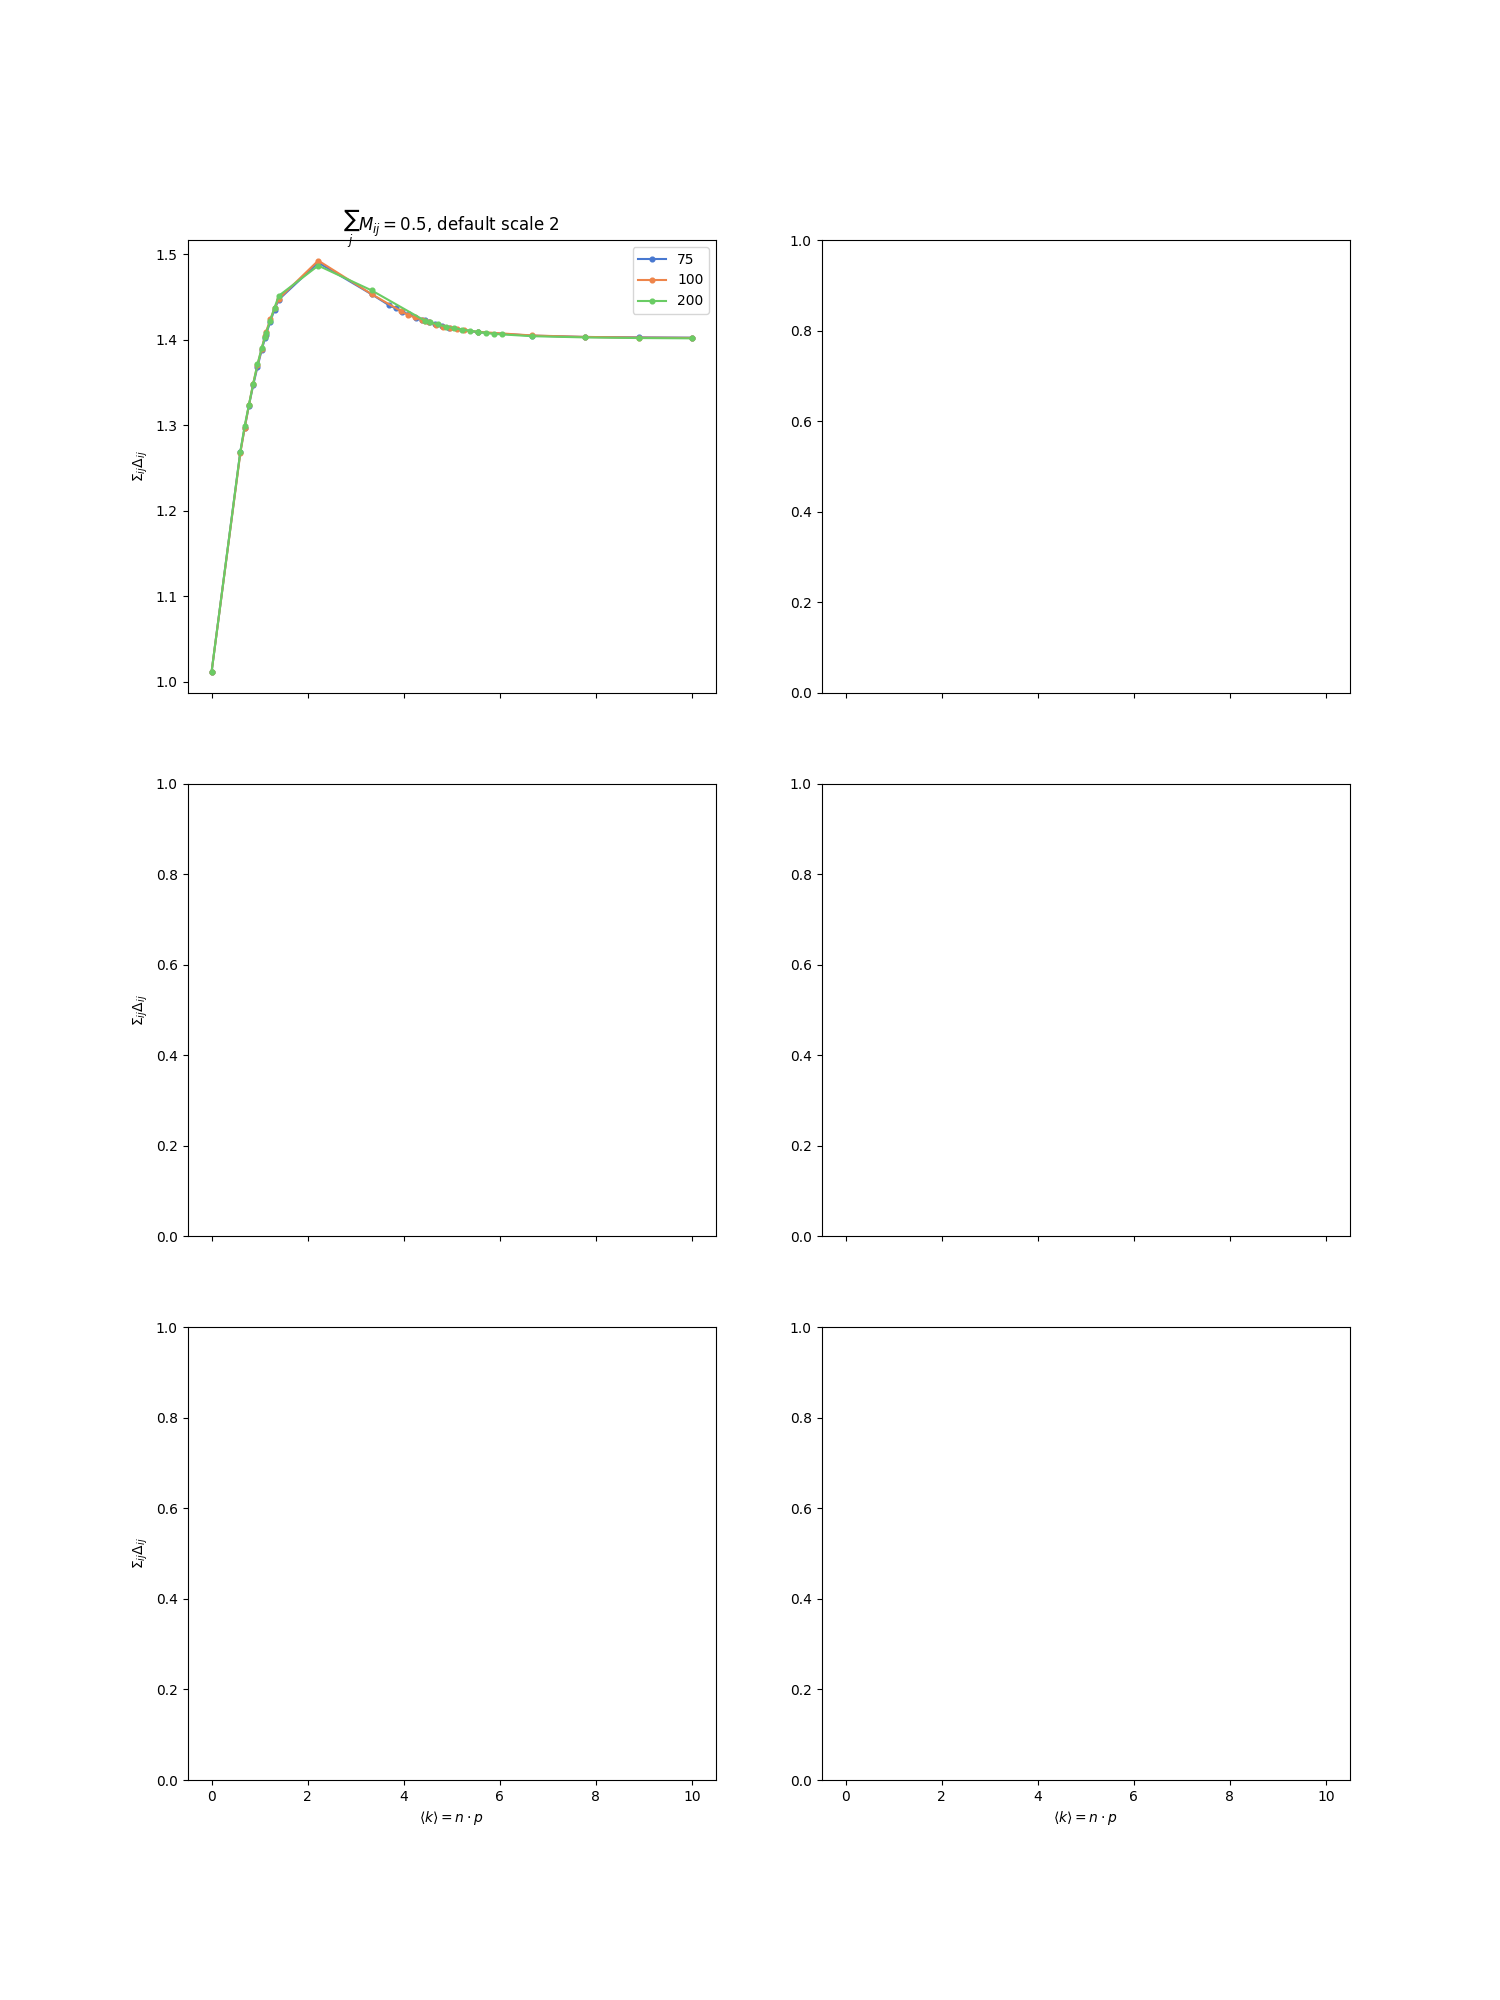

In [69]:
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15, 20))
def plot_val(l,ax, val, title=""):
    for N in Nlist[3:]:
        c = next(ccycle)
        test = l.loc[idx[N,:,val],['Delta','Delta var']]
        test_arr = test.values
        x = float(N)*test.reset_index(level=[0,2]).index.values
        y = np.array([np.sum(el)/(float(N)) for el in test_arr[:,0]])
        y_err = np.array([np.sqrt(np.sum(el)/(float(N*N))) for el in test_arr[:,1]])
        ax.plot(x,y, '-', marker='o', markersize=3.4, label=N,color=c)
        #ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
        ax.set_title(r'$\sum_j M_{ij} = $' + str(val) + title)
        ax.legend()

ax = axs[0,0]
val = 0.5
plot_val(df5_d2 ,ax, val, ", default scale 2")
axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#plt.errorbar(x, y, yerr=y_err, fmt='o')

plt.show()

<IPython.core.display.Javascript object>


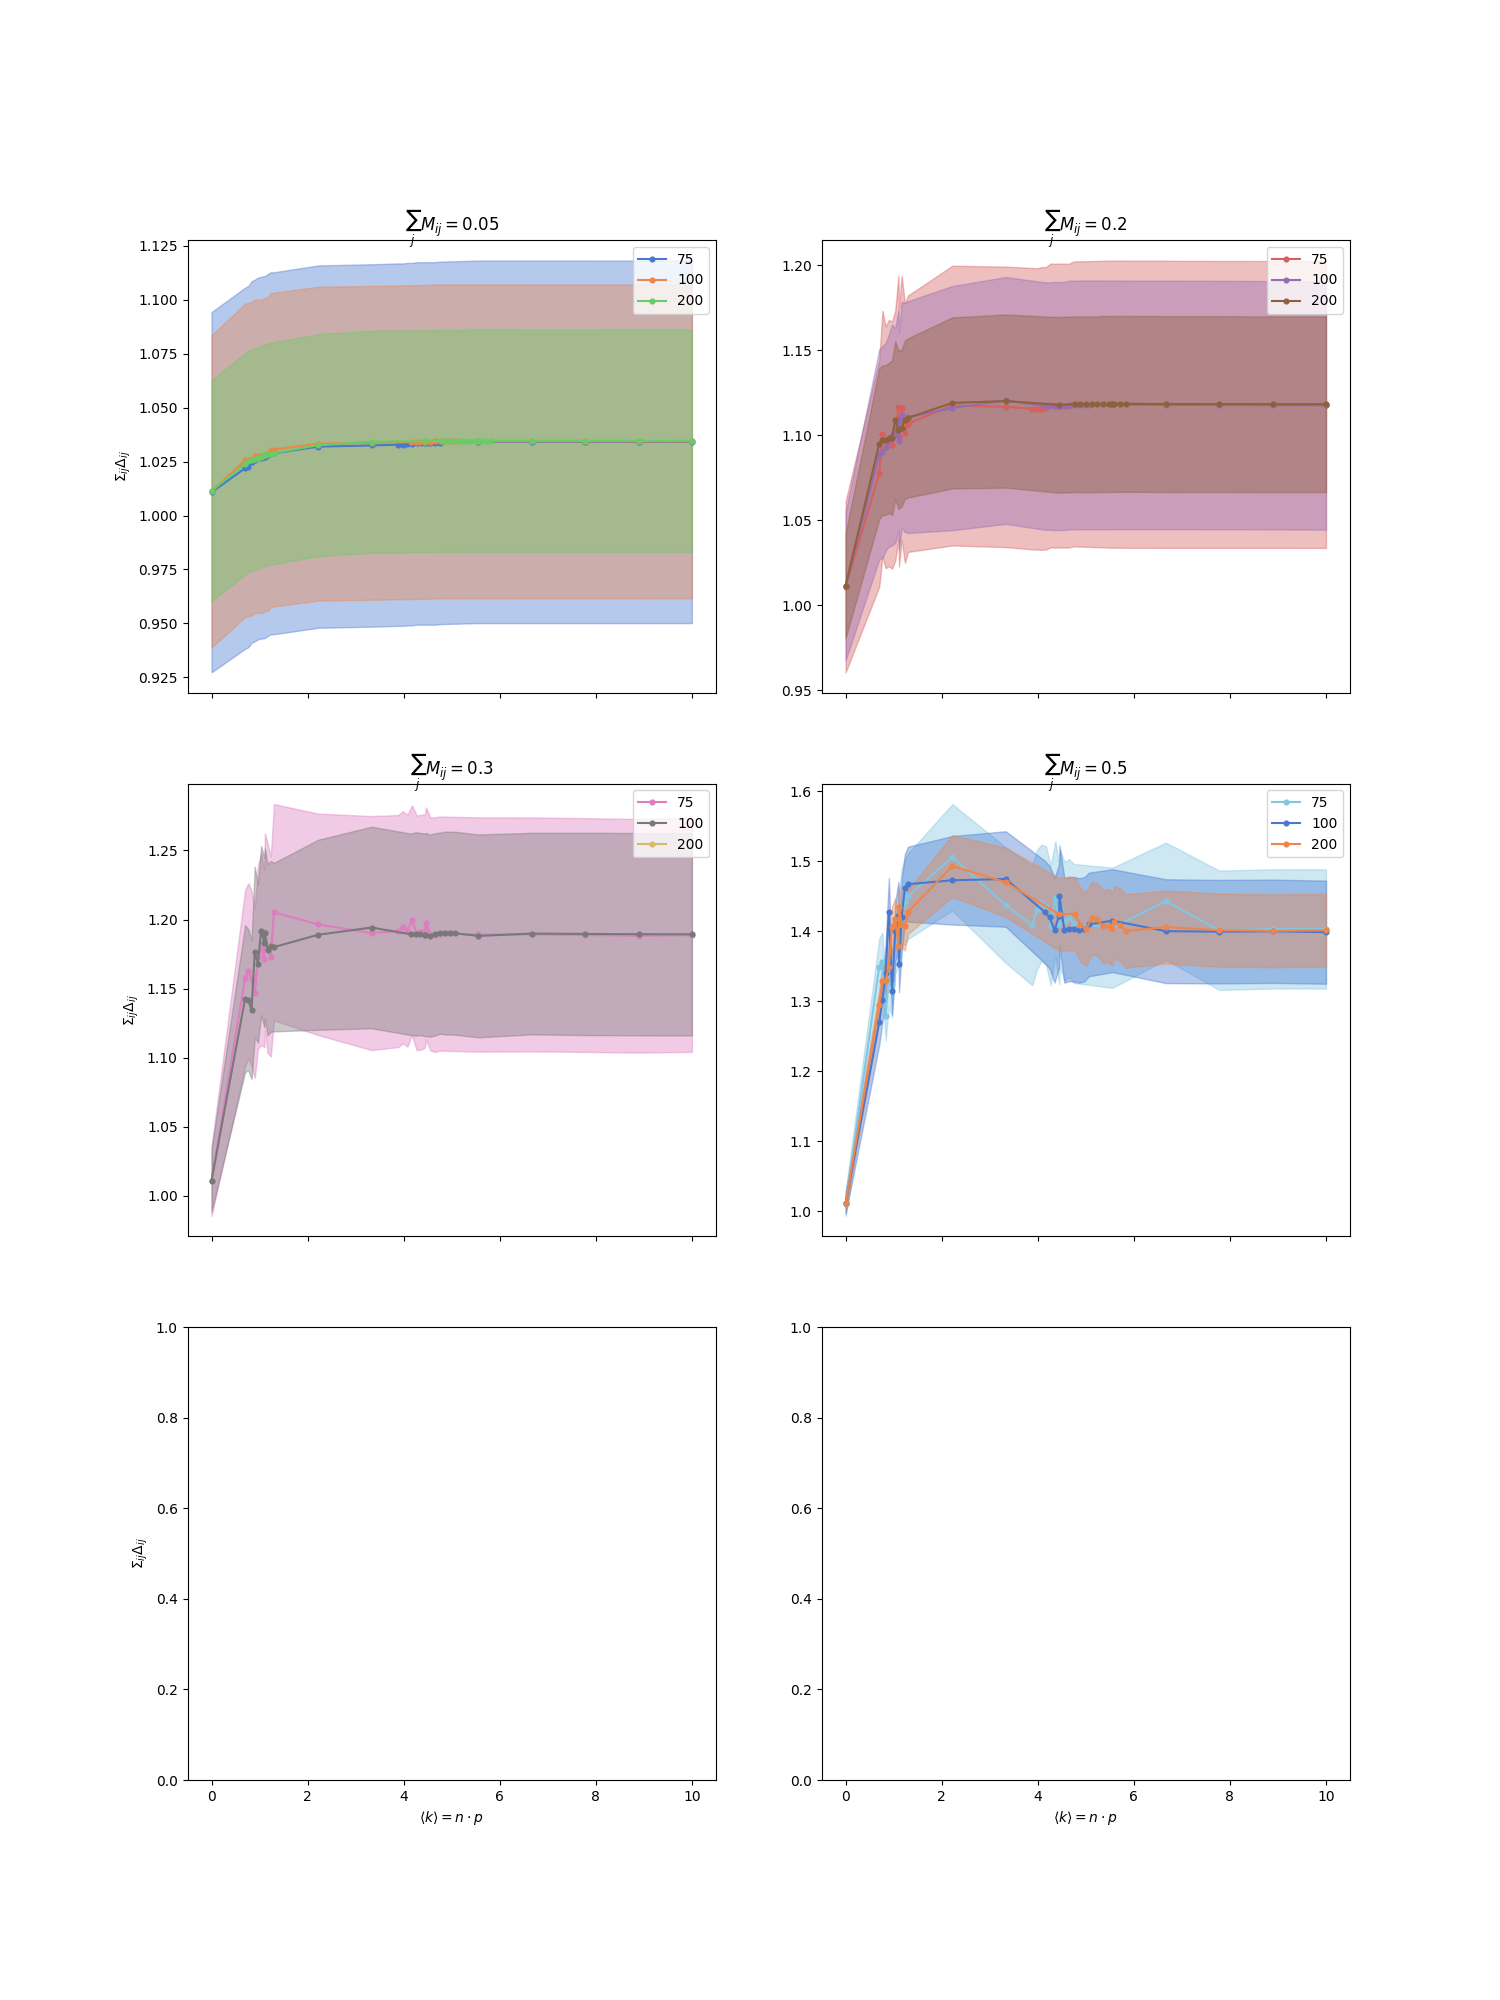

Text(0.5,0,'$\\langle k \\rangle = n \\cdot p$')

In [50]:
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15, 20))
def plot_val(l,ax, val):
    for N in Nlist[3:]:
        c = next(ccycle)
        test = l.loc[idx[N,:,val],['Delta','Delta var']]
        test_arr = test.values
        x = float(N)*test.reset_index(level=[0,2]).index.values
        y = np.array([np.sum(el)/(float(N)) for el in test_arr[:,0]])
        y_err = np.array([np.sqrt(np.sum(el)/(float(N*N))) for el in test_arr[:,1]])
        ax.plot(x,y, '-', marker='o', markersize=3.4, label=N,color=c)
        ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
        ax.set_title(r'$\sum_j M_{ij} = $' + str(val))
        ax.legend()

ax = axs[0,0]
val = 0.05
plot_val(combined, ax, val)
ax = axs[0,1]
val = 0.2
plot_val(combined, ax, val)
ax = axs[1,0]
val = 0.3
plot_val(combined, ax, val)
ax = axs[1,1]
val = 0.5
plot_val(combined, ax, val)
axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')

In [10]:
#res = [r.get() for r in async_res]
results = []
res = res_0_4
tmp = combine_results(*res)
results.append(tmp[0])
while len(tmp[1]):
    tmp = combine_results(*tmp[1])
    results.append(tmp[0])
results[1]

{'Assets': [array([1.01124903, 1.01189336, 1.0108696 , 1.01146834, 1.01155754,
         1.01187135, 1.01081859, 1.01116602, 1.01139831, 1.01145916,
         1.0111476 , 1.01131964, 1.01141692, 1.01195999, 1.01124664,
         1.01105331, 1.01132615, 1.01148874, 1.01114519, 1.01172413,
         1.01152202, 1.01102294, 1.01104297, 1.01124928, 1.01107539,
         1.01133666, 1.01127269, 1.01080839, 1.01121245, 1.01142305]),
  array([1.01124903, 1.01189336, 1.0108696 , 1.01146834, 1.01155754,
         1.01187135, 1.01081859, 1.01116602, 1.01139831, 1.01145916,
         1.0111476 , 1.01131964, 1.01141692, 1.01195999, 1.01124664,
         1.01105331, 1.01132615, 1.01148874, 1.01114519, 1.01172413,
         1.01152202, 1.01102294, 1.01104297, 1.01124928, 1.01107539,
         1.01133666, 1.01127269, 1.01080839, 1.01121245, 1.01142305]),
  array([1.01124903, 1.01189336, 1.0108696 , 1.01146834, 1.01155754,
         1.01187135, 1.01081859, 1.01116602, 1.01139831, 1.01145916,
         1.0111476 ,

In [50]:
bb = combine_results(*aa[1])
bb[1]

[]